In [3]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd

In [4]:
tf.__version__

'2.11.0'

In [5]:
%load_ext tensorboard

In [6]:
logdir = 'log'

In [7]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28 ,1))

train_images, test_images = train_images / 255.0, test_images / 255.0

classes = [0,1,2,3,4,5,6,7,8,9]

11490434/11490434 [==============================] - 0s 0us/step


In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [9]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=train_images,
          y=train_labels,
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 90s 47ms/step - loss: 0.1451 - accuracy: 0.9563 - val_loss: 0.0506 - val_accuracy: 0.9823
Epoch 2/5
1875/1875 [==============================] - 119s 63ms/step - loss: 0.0456 - accuracy: 0.9854 - val_loss: 0.0351 - val_accuracy: 0.9885
Epoch 3/5
1875/1875 [==============================] - 134s 71ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0307 - val_accuracy: 0.9897
Epoch 4/5
1875/1875 [==============================] - 122s 65ms/step - loss: 0.0255 - accuracy: 0.9921 - val_loss: 0.0283 - val_accuracy: 0.9911
Epoch 5/5
1875/1875 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9939

In [42]:
y_true = test_labels
y_pred = np.argmax(model.predict(test_images), axis=-1)

313/313 [==============================] - 6s 17ms/step


In [28]:
classes = [0,1,2,3,4,5,6,7,8,9]

In [43]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

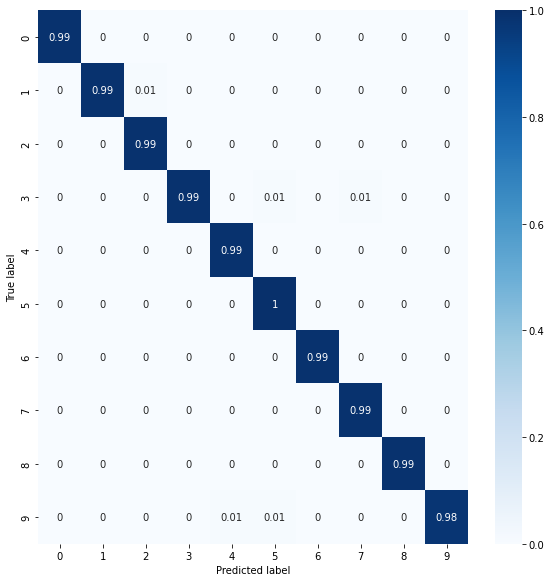

In [44]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes,
                          columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [46]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))

model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

model1.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
file_writer = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred = np.argmax(model.predict(test_images), axis=-1)

  con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=test_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,
                            index = classes,
                            columns = classes)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  
  buf = io.BytesIO()
  plt.savefig(buf, format='png')

  plt.close(figure)
  buf.seek(0)
  image = tf.image.decode_png(buf.getvalue(), channels=4)

  image = tf.expand_dims(image, 0)

  # Log the confusion matrix as an image summary.
  with file_writer.as_default():
    tf.summary.image('Confusion Matrix', image, setp=epoch)

logdir = 'logs/image'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [ ]:
model1.fit(
    train_images,
    train_labels,
    epochs=5,
    verbose=0,
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(test_images, test_labels)
)

In [ ]:
# Start TensorBoard.
%tensorboard --logdir logs/images